Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Geographical and Spatial Analysis

In [73]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import twitter
import nltk
import re
import networkx as nx
import sys
import os
import json
import time
import urllib
import webbrowser
import codecs
import Levenshtein

from datetime import datetime
from datetime import timedelta
from itertools import chain
from itertools import cycle
from bs4 import BeautifulSoup
from nominatim import Nominatim
from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
import plotly as py
import plotly.graph_objs as go

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

#Install http://www.graphviz.org/ & 
#Instal https://pypi.python.org/pypi/pydotplus
import pydotplus

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)
#plt.switch_backend('Agg')

#### Specifying the path to the files

In [2]:
templates = "../templates/"
outputs = "../outputs/"

dotfile = "graph_retweet.dot"
pngfile = "graph_retweet.png"
protofile = "graph_retweet.html"
tweetsfile = "Tweets_dump.txt"
template_proto = 'template_protoviz.html'

pathdotfile = os.path.join(outputs,dotfile)
pathpngfile = os.path.join(outputs,pngfile)
pathprotofile = os.path.join(outputs,protofile)
pathtweetsfile = os.path.join(outputs,tweetsfile)
pathtemplate = os.path.join(templates,template_proto)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt + ['',' ','-','rt']

### Using geographical resources within Python

In [3]:
#https://pypi.python.org/pypi/geopy  

gg.OpenMapQuest()
geolocator = gg.GoogleV3()

To geolocate a query to an address and coordinates:

In [4]:
logradouro = "Dona Mario ana, Botafoga" #Note that there are typos in the names
address, (latitude, longitude) = geolocator.geocode(logradouro)
print(address)
print(latitude, longitude)

Rua Dona Mariana - Botafogo, Rio de Janeiro - RJ, Brazil
-22.953195 -43.1885094


In [5]:
#Measuring editing distances between names:
Levenshtein.ratio('Dona Mariano, Botafoga', 'Rua Dona Mariana - Botafogo')

0.7755102040816326

In [6]:
#https://developers.google.com/maps/documentation/staticmaps/
#http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251
#m – normal map k – satellite h – hybrid p – terrain

def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    google_maps_url = 'http://maps.google.com/maps?q={0}&loc:{1}+{2}&z={3}&t={4}&output=embed'.format(address,
                                                                                                     lat,
                                                                                                     lon,
                                                                                                     zoom,
                                                                                                     tmap,)
    display(IFrame(google_maps_url, '800px', '600px'))
    
gmap(address, latitude, longitude,17,'k')

To find the address corresponding to a set of coordinates:

In [7]:
addresses = geolocator.reverse("-15.798,-47.865")
for address in addresses:
    print(address)

139 - Praça dos Três Poderes - Brasília, DF, 70297-400, Brazil
Praça dos Três Poderes - Brasília, DF, 70297-400, Brazil
Brasília - Brasilia, Federal District, Brazil
Brasilia, Federal District, Brazil
Asa Sul Entrequadra Sul 414/415 - Brasília, DF, 70297-400, Brazil
Brasilia - Federal District, Brazil
Brasilia - Federal District, Brazil
Brazil


### Using Plotly

In [71]:
data = dict (
    type = 'choropleth',
    locations = ['China','Canada','Brazil'],
    locationmode='country names',
    colorscale = ['Viridis'],
    z=[10,20,30])

In [74]:
map = go.Figure(data=[data])
py.offline.plot(map)

'file:///Documents/MMD/notebooks/temp-plot.html'

In [77]:
pwd

'/Documents/MMD/notebooks'

In [76]:
df = pd.read_csv("../datasets/CSVs/hapiness2017.csv")

data = dict (
    type = 'choropleth',
    locations = df['Country'],
    locationmode='country names',
    colorscale = ['Viridis'],
    z=df['Happiness.Score'])

map = go.Figure(data=[data])
py.offline.plot(map)

FileNotFoundError: File b'../datasets/CSVs/hapiness2017.csv' does not exist

### Using Python and QGIS for geospatial visualizations - a Case Study  
https://www.airpair.com/python/posts/using-python-and-qgis-for-geospatial-visualization  

In [8]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [9]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        shape = row_data[3].text
        duration = row_data[4].text
        data.append((date_time, city, state, shape, duration))
    return data

In [10]:
# get the index page
raw_page = urllib.request.urlopen(index_url)
source = BeautifulSoup(raw_page, "html5lib")
# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like 06/2015
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe201808.html
Processing http://www.nuforc.org/webreports/ndxe201807.html
Processing http://www.nuforc.org/webreports/ndxe201806.html
Processing http://www.nuforc.org/webreports/ndxe201805.html
Processing http://www.nuforc.org/webreports/ndxe201804.html
Processing http://www.nuforc.org/webreports/ndxe201803.html
Processing http://www.nuforc.org/webreports/ndxe201802.html
Processing http://www.nuforc.org/webreports/ndxe201801.html
Processing http://www.nuforc.org/webreports/ndxe201712.html
Processing http://www.nuforc.org/webreports/ndxe201711.html
Processing http://www.nuforc.org/webreports/ndxe201710.html
Processing http://www.nuforc.org/webreports/ndxe201709.html


In [11]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","shape","duration_description"])

In [12]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2018-08-09 23:41:00,Wildwood Crest,NJ,Oval,4 minutes
1,2018-08-09 21:30:00,White Sulphur Springs,WV,Light,10 minutes
2,2018-08-09 21:00:00,Sandy Springs,GA,Light,10 minutes
3,2018-08-09 21:00:00,Magnolia,DE,Egg,2 minutes
4,2018-08-09 20:25:00,San Diego (17 miles north of),CA,Diamond,20 minutes


In [14]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad')
ufos_df = ufos_df.dropna() 

In [15]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2018-08-09 23:41:00,Wildwood Crest,NJ,Oval,4 minutes
1,2018-08-09 21:30:00,White Sulphur Springs,WV,Light,10 minutes
2,2018-08-09 21:00:00,Sandy Springs,GA,Light,10 minutes
3,2018-08-09 21:00:00,Magnolia,DE,Egg,2 minutes
4,2018-08-09 20:25:00,San Diego (17 miles north of),CA,Diamond,20 minutes


#### Engineering time

In [16]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    text = text.replace('<','')
    text = text.replace('>','')
    text = text.replace('?','')
    text = text.replace('+','')
    text = text.replace('~','')
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour",'Currently']
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600,10]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return 0

In [17]:
# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration_description"].apply(infer_duration_in_seconds)

# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()

In [18]:
ufos_df.head()

,start,city,state,shape,duration_description,duration_secs,end
0,2018-08-09 23:41:00,Wildwood Crest,NJ,Oval,4 minutes,240,2018-08-09 23:45:00
1,2018-08-09 21:30:00,White Sulphur Springs,WV,Light,10 minutes,600,2018-08-09 21:40:00
2,2018-08-09 21:00:00,Sandy Springs,GA,Light,10 minutes,600,2018-08-09 21:10:00
3,2018-08-09 21:00:00,Magnolia,DE,Egg,2 minutes,120,2018-08-09 21:02:00
4,2018-08-09 20:25:00,San Diego (17 miles north of),CA,Diamond,20 minutes,1200,2018-08-09 20:45:00


#### Finding Locations

In [19]:
# http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
# https://github.com/twain47/Nominatim/blob/master/docs/Installation.md
geolocator = Nominatim()

geolocator.query('Newport News')
#geolocator.query("Houston, TX")

[{'boundingbox': ['36.930691', '37.2206658', '-76.646093', '-76.36161'],
  'class': 'place',
  'display_name': 'Newport News, Newport News City, Virginia, United States of America',
  'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png',
  'importance': 0.70997691224355,
  'lat': '36.9786449',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'lon': '-76.4321089',
  'osm_id': '206655',
  'osm_type': 'relation',
  'place_id': '178546686',
  'type': 'city'},
 {'boundingbox': ['37.0728977', '37.0731352', '-76.4785431', '-76.4780971'],
  'class': 'amenity',
  'display_name': 'Station 8, Kingstowne Drive, Kingstowne Apartments, Deer Park, Newport News, Newport News City, Virginia, 23606, United States of America',
  'icon': 'https://nominatim.openstreetmap.org/images/mapicons/amenity_firestation3.p.20.png',
  'importance': 0.201,
  'lat': '37.0730099',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://o

In [20]:
#Be careful with too many queries made to the server in a short period of time

ufos_df["lat"] = 0
ufos_df["lon"] = 0
for i in range(len(ufos_df[0:10])):
    try:
        resp_json = geolocator.query(ufos_df['city'][i])
        ufos_df["lat"][i] = resp_json[0]['lat']
        ufos_df["lon"][i] = resp_json[0]['lon']
    except:
        ufos_df["lat"][i] = 0
        ufos_df["lat"][i] = 0
    time.sleep(1.5)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set

In [21]:
# http://stackoverflow.com/questions/17098654/how-to-store-data-frame-using-pandas-python
ufos_df.to_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df = pd.read_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df.head(10)

,start,city,state,shape,duration_description,duration_secs,end,lat,lon
0,2018-08-09 23:41:00,Wildwood Crest,NJ,Oval,4 minutes,240,2018-08-09 23:45:00,38.9748351,-74.8335015
1,2018-08-09 21:30:00,White Sulphur Springs,WV,Light,10 minutes,600,2018-08-09 21:40:00,37.7965149,-80.2975734
2,2018-08-09 21:00:00,Sandy Springs,GA,Light,10 minutes,600,2018-08-09 21:10:00,33.9242688,-84.3785379
3,2018-08-09 21:00:00,Magnolia,DE,Egg,2 minutes,120,2018-08-09 21:02:00,33.2670725,-93.2393341
4,2018-08-09 20:25:00,San Diego (17 miles north of),CA,Diamond,20 minutes,1200,2018-08-09 20:45:00,0,0
5,2018-08-09 04:55:00,Downington,PA,Triangle,15 minutes,900,2018-08-09 05:10:00,40.331676,-76.7811298
6,2018-08-09 01:30:00,Burnaby (Canada),BC,Changing,2+ hours,7200,2018-08-09 03:30:00,49.2433804,-122.9725459
7,2018-08-09 01:00:00,Sturgis,SD,Formation,>30 seconds,30,2018-08-09 01:00:30,44.409707,-103.509079
8,2018-08-08 23:00:00,St. Peters,MO,Fireball,2 minutes,120,2018-08-08 23:02:00,38.8010514,-90.627881
9,2018-08-08 21:30:00,Bradford,RI,Circle,3 minutes,180,2018-08-08 21:33:00,53.7944229,-1.7519186


In [22]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv(os.path.join(outputs,'ufo_data.csv'),
                                                             index=False, 
                                                             encoding="utf-8")

### Using geographical resources for twitter Analysis

https://github.com/bear/python-twitter (before was http://code.google.com/p/python-twitter/)  
https://dev.twitter.com/docs  

Twitter API Keys  
Please generate yours...  
Go to http://twitter.com/apps/new to create an app and get these items  
See https://dev.twitter.com/docs/auth/oauth for more information on Twitter's OAuth implementation  
https://dev.twitter.com/rest/reference/get/account/verify_credentials  
https://dev.twitter.com/docs/auth/oauth  
https://dev.twitter.com/apps/new  

Inspiration: http://onemilliontweetmap.com/  

In [23]:
with open('twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

Acessing Twitter (with or without authentication)

In [24]:
#api = twitter.Api() # Accessing with no authentication
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret)

In [25]:
print(api.VerifyCredentials())

{"created_at": "Thu Apr 09 10:44:07 +0000 2009", "description": "Researcher and Professor", "favourites_count": 28, "followers_count": 501, "friends_count": 145, "id": 29959702, "lang": "pt", "listed_count": 17, "location": "Rio de Janeiro", "name": "Renato Rocha Souza", "profile_background_color": "9AE4E8", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_image_url": "http://pbs.twimg.com/profile_images/503088023/Renato2_normal.JPG", "profile_link_color": "0084B4", "profile_sidebar_fill_color": "DDFFCC", "profile_text_color": "333333", "screen_name": "rrsouza", "status": {"created_at": "Sun Mar 18 00:32:30 +0000 2018", "favorite_count": 1, "id": 975168027816873985, "id_str": "975168027816873985", "in_reply_to_screen_name": "fccoelho", "in_reply_to_status_id": 974792170917056512, "in_reply_to_user_id": 7433062, "lang": "pt", "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "text": "@fccoelh

#### Lexical Analysis

Recent (random) public messages

In [26]:
msgpublicas = api.GetStreamSample()

In [27]:
for i in range(15):
    tweet = next(msgpublicas)
    if 'text' in tweet:
        print(u'{}\n'.format(tweet['text']))

اللهم إنك جميلٌ تحب الجمال فاللهُم جمّل أيامنا وجمّل حظوظنا وجمّل أقوالنا وجمّلنا بأحسن الاخلاق

oakton is so incompetent that they cant even make schedules properly without something going wrong

@steved4ve April! I'm working hard on edits! Gotta make sure it's good enough to live up to that cover! 😁🔥🔥🔥

RT @squidslippers: one time in high school i was giving my friend a ride home and the girl he was texting asked if he could give her a ride…

RT @Vitoriamaori: @RodrigoRochx ela disse tudo, eu precisava ler isso.



Tweet Structure

In [28]:
while True:
    tweet = next(msgpublicas)
    if 'user' in tweet:
        break
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Aug 13 19:45:53 +0000 2018',
 'entities': {'hashtags': [{'indices': [21, 52],
    'text': 'الشورُ_المهدويُّ_أمانٌ_للشبابِ'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 825429682648662016,
    'id_str': '825429682648662016',
    'indices': [3, 19],
    'name': 'إعلام الشامية',
    'screen_name': 'media_alshaamia'}]},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 1029091692127969282,
 'id_str': '1029091692127969282',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'ar',
 'place': None,
 'quote_count': 0,
 'reply_count': 0,
 'retweet_count': 0,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Jun 27 21:36:39 +0000 2018',
  'display_text_range': [0, 140],
  '

In [29]:
Image(url='http://mike.teczno.com/img/raffi-krikorian-map-of-a-tweet.png')

Recent messages from an user

In [30]:
msguser = api.GetUserTimeline(tweet['user']['id'])
print([s.text for s in msguser])

['RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشبابِ\n\n المركز الإعلامي-إعلام الشامية\n\nصلاة العشاءين جماعة في جامع السيد الشهيد محمد باقر ال…', 'RT @media_alshaamia: من طه من طه هاك أخذ فتواها[ أداء. زكي النائلي]..{كلمات..وسام الكناني}\nhttps://t.co/neVCSlXudT', 'RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشباب\n\n المركز الإعلامي-إعلام الشامية\nخطيب جمعة الشامية :: المؤمن ومواجهته للتحديات والصعاب\nh…', 'RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشبابِ\n\n المركز الإعلامي-إعلام الشامية\n\n"علامات الوقف بالقران"  عنوان درس السيد يوسف الحسيني…', 'RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشبابِ\n\n المركز الإعلامي-إعلام الشامية\n\nالوكيل الشرعي يحث المؤمنين على المواظبة بالوجوبات الع…', 'RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشبابِ\n\n المركز الإعلامي-إعلام الشامية\n\nالشيخ الجناحي يلقي درسًا في تلاوة القرآن الكريم\nhttps…', 'RT @media_alshaamia: #الشورُ_المهدويُّ_أمانٌ_للشبابِ\n\n المركز الإعلامي-إعلام الشامية\nمجلس عزاء شور مهدوي في هيأة شور قائم آل محمد (عجل ا

Recent messages from the authenticated user

In [35]:
msguser = api.GetUserTimeline('29959702')
print([s.text for s in msguser])

['@fccoelho Parece que foi revogado... seria absurdo!', 'https://t.co/60gS89BY1Z #sif17 @avilarenata', '#SIF17 Digital Rights https://t.co/3Z3TLEewBZ', 'http://t.co/5l4lGVKiBG #FGV #emap', 'Olá Pessoal! Fiquem atentos à aula de Modelagem e Mineração de Dados... Hoje análises com Twitter!', 'Mais um curioso fenômeno dos nossos tempos: #LeakForJLaw Or maybe #LeakForPerverts ?', 'RT @mashable: 8 Brutally Honest Facebook Notifications That Need to Exist Now http://t.co/wwFQ1hut9x http://t.co/b2GjxcNb6D', '#Cite10CoisasQueSuaMãeFala come alguma coisa antes para não chegar na festa esfomeado', 'Implicações do Big Data para as questões de privacidade: http://t.co/WDJwxpOr9d', 'Resultados da seleção do Mestrado em Modelagem Matemática da Informação - turma 2013 saem nesta sexta, 08/02. #FGV #EMAp', 'RT @PyPLN: We just released the very first version (0.1.0) of pypln.api -- a Python library to programatically access @PyPLN Web! http:/ ...', "Men's Fitness UK by Dennis Publishing Ltd http://t.co

After authentication, more options are available

In [36]:
userfollow = api.GetFriends()
print([u.name for u in userfollow])

['Star Control', '@Team9Spokes', 'programador andarilho', 'Ricky Gervais', 'Thomas Power', 'Randy Gage', 'Rosiene Dilly', 'The Web Foundation', 'Appus', 'Renata Avila', 'Golala Ruhani', 'Sandi Chimpala', 'Malavika Jayaram', 'Sthlm Internet Forum', 'NetApp Deutschland', 'Lu.CaaS', 'Carla Codeço Coelho', 'Overleaf', 'Cláudio Berrondo', 'Flávio Amieiro', 'Pablo Cerdeira', 'Cut the Rope', 'Machinalis', 'MiningTheSocialWeb', 'CNET News', 'ReadWrite', 'TNW', 'CNET', 'The Verge', 'Engadget', 'Lifehacker', 'Gizmodo', 'WIRED', 'TechCrunch', 'Ian Ozsvald', 'CNPq', 'Claudio Gnoli', 'strongsteam', 'Diana Maynard', 'Joyce Figueiró', 'Álvaro Justen', 'PyPLN', 'Open Source For You', 'TechRepublic', 'ZDNet', 'Twitter API', 'Udacity', 'Clarissa', 'Roberto R.S.Sobrinho', 'Luana Sales', 'Sensacionalista', 'André Branco', 'CMA', 'Asla Sá', 'Renata Teixeira', 'FGV EMAp', 'FGV', 'FGV Marketing', 'FGV CPDOC', 'Globant Brasil', 'Sheffield NLP', 'Débora Pereira', 'André Andrade', "O'Reilly Radar", 'Virgilio Al

Searching for a term in tweets

In [37]:
def search_for_term(termo, pages, results):
    '''Search and return tweets on a subject (5 pages of 100 results each)
    Save results in a file defined in "pathtweetsfile" '''
    search_results = []
    tweets = []
    tweets_txt = []
    tweets_words = []
    names = []
    last = api.GetSearch(term=termo, count=1)
    search_results.append(last)
    list_ids = []
    list_ids.append(last[0].id)
    for i in range(pages):
        id_last = last[0].id
        new_tweets = api.GetSearch(term=termo, count=results, max_id=min(list_ids))
        for i in range(len(new_tweets)):
            list_ids.append(new_tweets[i].id)
        search_results.append(new_tweets)
    for i in range(len(search_results)):
        for j in range(len(search_results[i])):
            tweets.append(search_results[i][j])
    tweets_txt += [tweet.text.split(u' ') for tweet in tweets]
    for i in range(len(tweets)):
        tweets_words += [word.lower().strip(u':@&$!?') for word in tweets_txt[i]]
    for i in range(len(tweets)): 
        names += [word.strip(u':@&$!?') for word in tweets_txt[i] if word.istitle() and len(word) > 2]
    with open(pathtweetsfile,'w') as out:
        for tweet in tweets_txt:
            out.write(u'\n{}'.format(tweet))
    return tweets, tweets_txt, tweets_words, names

def lexical_diversity(text):
    return len(text) / len(set(text))

In [38]:
twitter_query = u'macron'

search = api.GetSearch(twitter_query)
print([s.text for s in search])

['Le traitre en chef au pouvoir va s’occuper d’un Français inculpé pour djihâdisme au Maroc, à la demande de sa mère.… https://t.co/rCFYQtheKn', 'Je comprends la compassion de #Macron envers la maman de #Thomas emprisonné au Maroc Mais aucun geste aucun signe d… https://t.co/OrcEEQap2F', '«Les mères de Français assassinés sont moins bien considérées que les mères de tueurs par #Macron»: le Net s’enflam… https://t.co/5c7eXTkn1j', "RT @garbo68: Macron n'a pas répondu à l'appel désespéré de la maman d'Adrien , mais reçoit celle d'un terroriste incarcéré au Maroc https:/…", 'RT @ORageetDesepoir: Finies les vacances "studieuses" 🚨Les TUCHE s\'amusent !!! Mémé  incapable de nager ... se fait balader en jet-ski, ens…', "@PhilippeSANTET @fhollande @EmmanuelMacron @MLePen_officiel Et bien on continue de tourner en rond. Visiblement Macron, c'est mieux...", "RT @rsistons: Echec de la politique de #Macron \nà comparer avec la réussite au #Portugal (contre la politique d'austérité)\n\nhttps://t.co

Using our customized function that retrieves 5 x 100 tweets

In [39]:
tweets, tweets_txt, tweets_words, names = search_for_term(twitter_query,5,10)
    
print('Word count: {}'.format(len(tweets_words)))
print('Repertoire: {}'.format(len(set(tweets_words))))
print('Lexical diversity: {}'.format(lexical_diversity(tweets_words)))

Word count: 1003
Repertoire: 480
Lexical diversity: 2.089583333333333


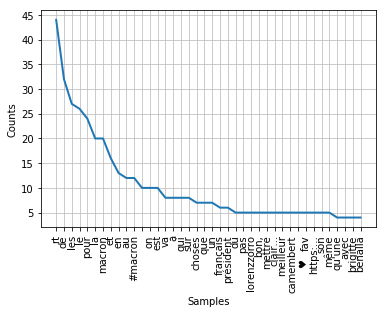

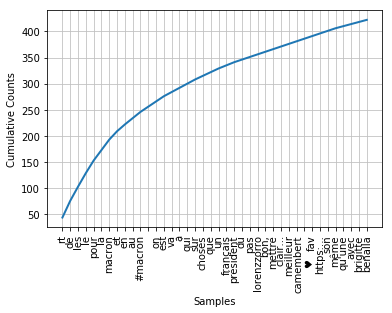

In [40]:
freq_dist = nltk.FreqDist(tweets_words)
freq_dist.plot(40)
freq_dist.plot(40, cumulative = True)

In [41]:
#print('10 most frequent words')
print(freq_dist.most_common())

[('rt', 44), ('de', 32), ('les', 27), ('le', 26), ('pour', 24), ('la', 20), ('macron', 20), ('et', 16), ('en', 13), ('au', 12), ('#macron', 12), ('', 10), ('on', 10), ('est', 10), ('va', 8), ('à', 8), ('qui', 8), ('sur', 8), ('choses', 7), ('que', 7), ('un', 7), ('français', 6), ('président', 6), ('du', 5), ('pas', 5), ('lorenzzorro', 5), ('bon,', 5), ('mettre', 5), ('clair...', 5), ('meilleur', 5), ('\n\n🔃', 5), ('camembert\n♥️', 5), ('fav', 5), ('https:…', 5), ('son', 5), ('même', 5), ("qu'une", 4), ('avec', 4), ('brigitte', 4), ('benalla', 4), ('si', 4), ('puis', 4), ('une', 4), ('d’un', 3), ('contre', 3), ('ils', 3), ('vous', 3), ('via', 3), ('cette', 3), ("c'est", 3), ('ont', 3), ('a', 3), ('ce', 3), ('par', 3), ('des', 3), ('mère', 3), ('ses', 3), ('ne', 3), ('niet', 3), ('aan', 3), ('traitre', 2), ('chef', 2), ('pouvoir', 2), ('s’occuper', 2), ('inculpé', 2), ('djihâdisme', 2), ('maroc,', 2), ('demande', 2), ('sa', 2), ('mère.…', 2), ('https://t.co/rcfyqthekn', 2), ('gaga5012', 

In [42]:
print('Sorted list of words')
print(sorted(set(tweets_words)))

Sorted list of words
['', '\n\nde', '\n\nhttps://t.co/dxxw61mxyw', '\n\nmacron', '\n\n🔃', '\ndu', '\nil', '\n«quand', '\n➡', '"bleu-blanc-rouge"', '"et', '"l\'ex-collègue"', '"pleine', '#adrienperez', '#affairebenalla', '#bayrou', '#benalla,', '#emploi…', '#fakenews', '#glyphosate\xa0', '#hulot', '#hulot...\nalexis', '#jesoutienslescheminots\nle', '#joke.', '#kohler,', '#kohler.', '#lasvegas,', '#lemaire', '#lrem', '#macron', '#macron»', '#makeourplanetgreatagain', '#penicaud', '#pétition', '#ristournes', '#running', '#travert', '-', '..', '...', '13', '1ere', '2018', '38%…', '39%', '60bl', '_stalker_69_', 'a', 'aan', 'accusée', 'adrenaline1001', 'affaire', 'affaire,', 'affaires', 'afrikanen,', 'aides', 'aidés', 'akrouf,', 'alex_patriotefn', 'alexandre', 'amp;', 'anti-macron,', 'anticor_org', 'août', 'apprend', 'après', 'artistesfrance', 'asielzoeker', 'assassinés', 'assure', 'au', 'augmente', 'aussi…', 'aux', 'avancent."', 'avec', 'avril', 'avril\xa0!)', 'bassinrebel', 'beaucoup', 'be

Same as before, without stopwords. See variable "ignorewords"

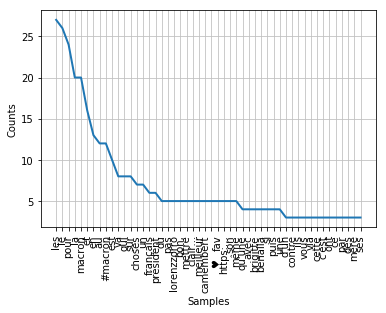

In [43]:
new_tweets_words = [word for word in tweets_words if word not in ignorewords]
    
freq_new = nltk.FreqDist(new_tweets_words)    
freq_new.plot(50)

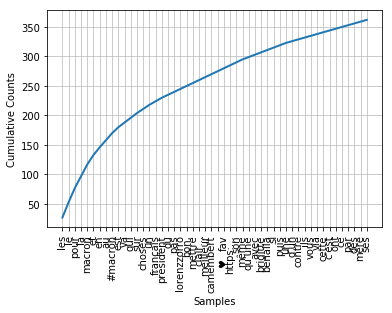

In [44]:
freq_new.plot(50, cumulative = True)

In [45]:
print('10 most frequent words')
print(freq_new.most_common())

10 most frequent words
[('les', 27), ('le', 26), ('pour', 24), ('la', 20), ('macron', 20), ('et', 16), ('en', 13), ('au', 12), ('#macron', 12), ('est', 10), ('va', 8), ('qui', 8), ('sur', 8), ('choses', 7), ('un', 7), ('français', 6), ('président', 6), ('du', 5), ('pas', 5), ('lorenzzorro', 5), ('bon,', 5), ('mettre', 5), ('clair...', 5), ('meilleur', 5), ('\n\n🔃', 5), ('camembert\n♥️', 5), ('fav', 5), ('https:…', 5), ('son', 5), ('même', 5), ("qu'une", 4), ('avec', 4), ('brigitte', 4), ('benalla', 4), ('si', 4), ('puis', 4), ('une', 4), ('d’un', 3), ('contre', 3), ('ils', 3), ('vous', 3), ('via', 3), ('cette', 3), ("c'est", 3), ('ont', 3), ('ce', 3), ('par', 3), ('des', 3), ('mère', 3), ('ses', 3), ('ne', 3), ('niet', 3), ('aan', 3), ('traitre', 2), ('chef', 2), ('pouvoir', 2), ('s’occuper', 2), ('inculpé', 2), ('djihâdisme', 2), ('maroc,', 2), ('demande', 2), ('sa', 2), ('mère.…', 2), ('https://t.co/rcfyqthekn', 2), ('gaga5012', 2), ('députés', 2), ('#lrem', 2), ('votent', 2), ("l'in

In [46]:
print('Sorted list of words')
print(sorted(set(new_tweets_words)))

Sorted list of words
['\n\nde', '\n\nhttps://t.co/dxxw61mxyw', '\n\nmacron', '\n\n🔃', '\ndu', '\nil', '\n«quand', '\n➡', '"bleu-blanc-rouge"', '"et', '"l\'ex-collègue"', '"pleine', '#adrienperez', '#affairebenalla', '#bayrou', '#benalla,', '#emploi…', '#fakenews', '#glyphosate\xa0', '#hulot', '#hulot...\nalexis', '#jesoutienslescheminots\nle', '#joke.', '#kohler,', '#kohler.', '#lasvegas,', '#lemaire', '#lrem', '#macron', '#macron»', '#makeourplanetgreatagain', '#penicaud', '#pétition', '#ristournes', '#running', '#travert', '..', '...', '13', '1ere', '2018', '38%…', '39%', '60bl', '_stalker_69_', 'aan', 'accusée', 'adrenaline1001', 'affaire', 'affaire,', 'affaires', 'afrikanen,', 'aides', 'aidés', 'akrouf,', 'alex_patriotefn', 'alexandre', 'amp;', 'anti-macron,', 'anticor_org', 'août', 'apprend', 'après', 'artistesfrance', 'asielzoeker', 'assassinés', 'assure', 'au', 'augmente', 'aussi…', 'aux', 'avancent."', 'avec', 'avril', 'avril\xa0!)', 'bassinrebel', 'beaucoup', 'benalla', 'benal

Counting specific words

In [47]:
print(new_tweets_words.count('poll'))
print(freq_new['voters']) #same as before
print(freq_new.freq('virginia')) #relative to the others

0
0
0.0


Eliminating small words or words with specific sizes

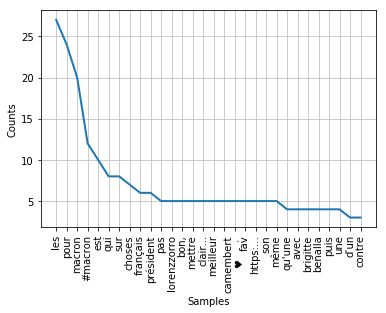

In [48]:
bigger_tweets_words = [word for word in new_tweets_words if len(word) > 2]
#mediumsized_tweets_words = [word for word in new_tweets_words if len(word) > 2 and len(word) < 9]
freq_bigger = nltk.FreqDist(bigger_tweets_words)    
freq_bigger.plot(30)

Citation Analysis

In [49]:
citacoes = [word for word in tweets_words if '@' in word]
#citacoes = [word for word in tweets_words if word.startswith('@')]
freq_citacoes = nltk.FreqDist(citacoes)
freq_citacoes.items()

dict_items([])

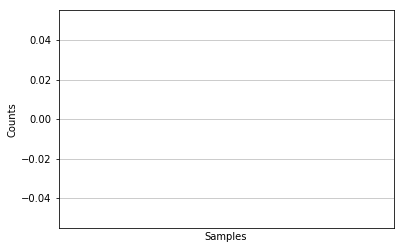

In [50]:
freq_citacoes.plot()

Hashtag Analysis

In [51]:
hashtags = [word for word in tweets_words if word.startswith('#')]
freq_hashtags = nltk.FreqDist(hashtags)
freq_hashtags.items()

dict_items([('#lrem', 2), ('#kohler.', 1), ('#macron', 12), ('#benalla,', 2), ('#macron»', 1), ('#hulot', 1), ('#fakenews', 1), ('#running', 1), ('#joke.', 1), ('#pétition', 2), ('#hulot...\nalexis', 1), ('#kohler,', 1), ('#makeourplanetgreatagain', 1), ('#glyphosate\xa0', 1), ('#travert', 1), ('#lemaire', 1), ('#adrienperez', 1), ('#affairebenalla', 1), ('#ristournes', 1), ('#penicaud', 1), ('#lasvegas,', 1), ('#bayrou', 1), ('#emploi…', 1), ('#jesoutienslescheminots\nle', 1)])

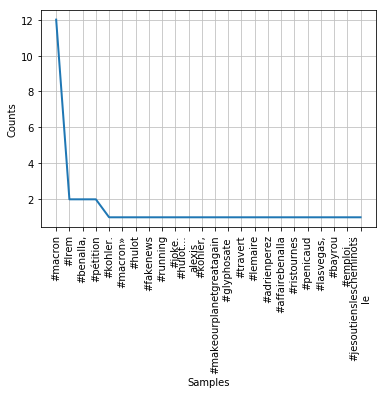

In [52]:
freq_hashtags.plot()

Analysis of Frequent words  
Can be used with any of the previous lists'''

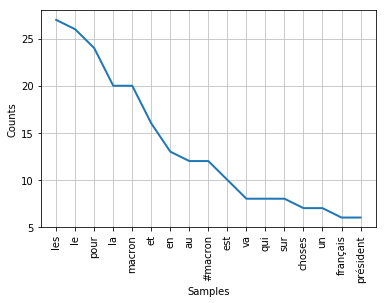

In [53]:
frequent_words = [word.lower() for word in new_tweets_words if tweets_words.count(word) > 5]
freq_dist2 = nltk.FreqDist(frequent_words)
freq_dist2.plot(40)

Words Sizes

In [54]:
freq_size_words = nltk.FreqDist([len(w) for w in new_tweets_words])
freq_size_words.items()

dict_items([(2, 135), (7, 88), (4, 111), (9, 47), (8, 70), (10, 38), (6, 90), (23, 18), (3, 130), (5, 61), (14, 10), (11, 27), (15, 10), (12, 22), (20, 2), (19, 4), (25, 1), (27, 1), (13, 6), (16, 2), (24, 1), (17, 1), (18, 1), (1, 1), (26, 1)])

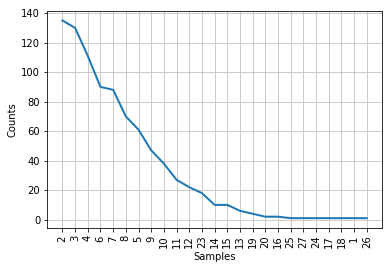

In [55]:
freq_size_words.plot()

Bigrams

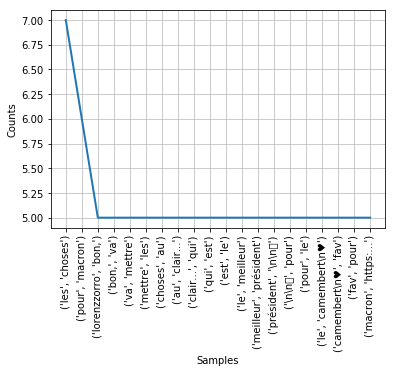

In [56]:
bigramas_tweets = nltk.bigrams(new_tweets_words)
freqbig = nltk.FreqDist(bigramas_tweets)
freqbig.plot(20)

Names (capitalized words)

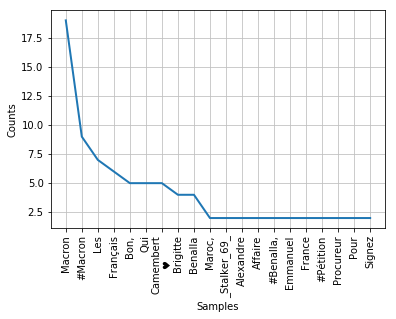

In [57]:
freq_names = nltk.FreqDist(names)
freq_names.plot(20)

#### Sentiment Analysis

In [58]:
badwords =   ['abandoned','abused','accused','addicted','afraid','aggravated',
              'aggressive','alone','angry','anguish','annoyed','anxious','apprehensive',
              'argumentative','artificial','ashamed','assaulted','at a loss','at risk',
              'atrocious','attacked','avoided','awful','awkward','bad','badgered','baffled',
              'banned','barren','beat','beaten down','belittled','berated','betrayed',
              'bitched at','bitter','bizzare','blacklisted','blackmailed','blamed','bleak',
              'blown away','blur','bored','boring','bossed-around','bothered','bothersome',
              'bounded','boxed-in','broken','bruised','brushed-off','bugged','bullied',
              'bummed','bummed out','burdened','burdensome','burned','burned-out',
              'caged in','careless','chaotic','chased','cheated','cheated on','chicken',
              'claustrophobic','clingy','closed','clueless','clumsy','coaxed',
              'codependent','coerced','cold','cold-hearted','combative','commanded',
              'compared','competitive','compulsive','conceited','concerned',
              'condescended to','confined','conflicted','confronted','confused',
              'conned','consumed','contemplative','contempt','contentious','controlled',
              'convicted','cornered','corralled','cowardly','crabby','cramped','cranky',
              'crap','crappy','crazy','creeped out','creepy','critical','criticized',
              'cross','crowded','cruddy','crummy','crushed','cut-down','cut-off','cynical',
              'damaged','damned','dangerous','dark','dazed','dead','deceived','deep',
              'defamed','defeated','defective','defenseless','defensive','defiant',
              'deficient','deflated','degraded','dehumanized','dejected','delicate',
              'deluded','demanding','demeaned','demented','demoralized','demotivated',
              'dependent','depleted','depraved','depressed','deprived','deserted',
              'deserving of pain/punishment','desolate','despair','despairing',
              'desperate','despicable','despised','destroyed','destructive',
              'detached','detest','detestable','detested','devalued','devastated',
              'deviant','devoid','diagnosed','dictated to','different','difficult',
              'directionless','dirty','disabled','disagreeable','disappointed',
              'disappointing','disapproved of','disbelieved','discardable','discarded',
              'disconnected','discontent','discouraged','discriminated','disdain',
              'disdainful','disempowered','disenchanted','disgraced','disgruntled',
              'disgust','disgusted','disheartened','dishonest','dishonorable',
              'disillusioned','dislike','disliked','dismal','dismayed','disorganized',
              'disoriented','disowned','displeased','disposable','disregarded',
              'disrespected','dissatisfied','distant','distracted','distraught',
              'distressed','disturbed','dizzy','dominated','doomed','double-crossed',
              'doubted','doubtful','down','down and out','down in the dumps',
              'downhearted','downtrodden','drained','dramatic','dread','dreadful',
              'dreary','dropped','drunk','dry','dumb','dumped','dumped on','duped',
              'edgy','egocentric','egotistic','egotistical','elusive','emancipated',
              'emasculated','embarrassed','emotional','emotionless','emotionally bankrupt',
              'empty','encumbered','endangered','enraged','enslaved','entangled','evaded',
              'evasive','evicted','excessive','excluded','exhausted','exploited','exposed',
              'fail','failful','fake','false','fear','fearful','fed up','flawed','forced',
              'forgetful','forgettable','forgotten','fragile','freaked out','frightened',
              'frigid','frustrated','furious','gloomy','glum','gothic','grey','grief','grim',
              'gross','grossed-out','grotesque','grouchy','grounded','grumpy','guilt-tripped',
              'guilty','harassed','hard','hard-hearted','harmed','hassled','hate','hateful',
              'hatred','haunted','heartbroken','heartless','heavy-hearted','helpless',
              'hesitant','hideous','hindered','hopeless','horrible','horrified','horror',
              'hostile','hot-tempered','humiliated','hung up','hung over','hurried','hurt',
              'hysterical','idiot','idiotic','ignorant','ignored','ill','ill-tempered',
              'imbalanced','imposed-upon','impotent','imprisoned','impulsive','in the dumps',
              'in the way','inactive','inadequate','incapable','incommunicative','incompetent',
              'incompatible','incomplete','incorrect','indecisive','indifferent',
              'indoctrinated','inebriated','ineffective','inefficient','inferior',
              'infuriated','inhibited','inhumane','injured','injusticed','insane',
              'insecure','insignificant','insincere','insufficient','insulted',
              'intense','interrogated','interrupted','intimidated','intoxicated',
              'invalidated','invisible','irrational','irritable','irritated',
              'isolated','jaded','jealous','jerked around','joyless','judged',
              'kept apart','kept away','kept in','kept out','kept quiet','labeled',
              'laughable','laughed at','lazy','leaned on','lectured to','left out',
              'let down','lied about','lied to','limited','little','lonely','lonesome',
              'longing','lost','lousy','loveless','low','mad','made fun of','man handled',
              'manipulated','masochistic','messed with','messed up','messy','miffed',
              'miserable','misled','mistaken','mistreated','mistrusted','misunderstood',
              'mixed-up','mocked','molested','moody','nagged','needy','negative',
              'nervous','neurotic','nonconforming','numb','nuts','nutty','objectified',
              'obligated','obsessed','obsessive','obstructed','odd','offended',
              'on display','opposed','oppressed','out of place','out of touch',
              'over-controlled','over-protected','overwhelmed','pain','panic','paranoid',
              'passive','pathetic','pessimistic','petrified','phony','picked on','pissed',
              'pissed off','plain','played with','pooped','poor','powerless','pre-judged',
              'preached to','preoccupied','predjudiced','pressured','prosecuted',
              'provoked','psychopathic','psychotic','pulled apart','pulled back',
              'punished','pushed','pushed away','put down','puzzled','quarrelsome',
              'queer','questioned','quiet','rage','raped','rattled','regret','rejected',
              'resented','resentful','responsible','retarded','revengeful','ridiculed',
              'ridiculous','robbed','rotten','sad','sadistic','sarcastic','scared',
              'scarred','screwed','screwed over','screwed up','self-centered','self-conscious',
              'self-destructive','self-hatred','selfish','sensitive','shouted at','shy',
              'singled-out','slow','small','smothered','snapped at','spiteful','stereotyped',
              'strange','stressed','stretched','stuck','stupid','submissive','suffering',
              'suffocated','suicidal','superficial','suppressed','suspicious','worse','worst'
              ,'bankrupcy','jobs','shit','#sob']

In [59]:
goodwords =  ['Abundant','Accomplished','Achieving','Active','Admirable','Adorable',
              'Adventurous','Admired','Affluent','Agreeable','Alert','Aligned','Alive',
              'Amazing','Appealing','Appreciate','Artistic','Astounding','Astute',
              'Attentive','Attractive','Auspicious','Authentic','Awake','Aware','Awesome',
              'Beaming','Beautiful','Better','Best','Blessed','Bliss','Bold','Bright','Brilliant',
              'Brisk','Buoyant','Calm','Capable','Centered','Certain','Charming',
              'Cheerful','Clear','Clever','Competent','Complete','Confident','Connected',
              'Conscious','Considerate','Convenient','Courageous','Creative','Daring',
              'Dazzling','Delicious','Delightful','Desirable','Determined','Diligent',
              'Discerning','Discover','Dynamic','Eager','Easy','Efficient','Effortless',
              'Elegant','Eloquent','Energetic','Endless','Enhancing','Engaging','Enormous'
              ,'Enterprising','Enthusiastic','Enticing','Excellent','Exceptional','Exciting'
              ,'Experienced','Exquisite','Fabulous','Fair','Far-Sighted','Fascinating',
              'Fine','Flattering','Flourishing','Fortunate','Free','Friendly','Fulfilled',
              'Fun','Generous','Genuine','Gifted','Glorious','Glowing','Good','Good-Looking',
              'Gorgeous','Graceful','Gracious','Grand','Great','Handsome','Happy','Hardy',
              'Harmonious','Healed','Healthy','Helpful','Honest','Humorous','Ideal',
              'Imaginative','Impressive','Industrious','Ingenious','Innovative','Inspired',
              'Intelligent','Interested','Interesting','Intuitive','Inventive','Invincible',
              'Inviting','Irresistible','Joyous','Judicious','Keen','Kind','Knowing','Leader',
              'Limitless','Lively','Loving','Lucky','Luminous','Magical','Magnificent',
              'Marvellous','Masterful','Mighty','Miraculous','Motivated','Natural','Neat',
              'Nice','Nurturing','Noble','Optimistic','Outstanding','Passionate','Peaceful',
              'Perfect','Persevering','Persistent','Playful','Pleasing','Plentiful','Positive',
              'Powerful','Precious','Prepared','Productive','Profound','Prompt','Prosperous',
              'Proud','Qualified','Quick','Radiant','Reasonable','Refined','Refreshing',
              'Relaxing','Reliable','Remarkable','Resolute','Resourceful','Respected',
              'Rewarding','Robust','Safe','Satisfied','Secure','Seductive','Self-Reliant',
              'Sensational','Sensible','Sensitive','Serene','Sharing','Skilful','Smart',
              'Smashing','Smooth','Sparkling','Spiritual','Splendid','Strong','Stunning',
              'Successful','Superb','Swift','Talented','Tenacious','Terrific','Thankful',
              'Thrilling','Thriving','Timely','Trusting','Truthful','Ultimate','Unique',
              'Valiant','Valuable','Versatile','Vibrant','Victorious','Vigorous','Vivacious',
              'Vivid','Warm','Wealthy','Well','Whole','Wise','Wonderful','Worthy','Young',
              'Youthful','Zeal','Zest']

In [60]:
def percentage(count, total):
    return 100 * count / float(total)

In [61]:
def sentiment_analysis(texto, goodwords, badwords):
    '''
    Not a sophisticated one, but the main idea is present.
    Please read: http://alias-i.com/lingpipe/demos/tutorial/sentiment/read-me.html
    '''
    goodness = 0
    badness = 0    
    for word in goodwords:
        goodness += percentage(texto.count(word.lower()), len(texto))
    for word in badwords:
        badness += percentage(texto.count(word.lower()), len(texto))
    if badness:
        ratio = goodness/float(badness)
    print(u'Grau de negatividade: {}'.format(badness))
    print(u'Grau de positividade: {}'.format(goodness))
    if badness:
        print(u'Razão: {}'.format(ratio))
    return goodness, badness

In [62]:
sentiment_analysis(tweets_words, goodwords, badwords);

Grau de negatividade: 0.0
Grau de positividade: 0.0


#### Geographic Analysis

https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb  

In [63]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 20:
    tweet = next(msgpublicas)
    if 'coordinates' in tweet.keys() and tweet['coordinates'] != None:
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'Usuário {} nas coordenadas {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

Usuário 477769710 nas coordenadas [40.78664145, 30.4146724]
Usuário 44432548 nas coordenadas [41.902273, 12.454032]
Usuário 2268729886 nas coordenadas [41.037341, 28.968659]
Usuário 25772897 nas coordenadas [36.1626638, -86.7816016]
Usuário 230487950 nas coordenadas [31.5084926, -9.7595041]
Usuário 334927302 nas coordenadas [29.240991, -81.0699462]
Usuário 249858456 nas coordenadas [40.42743, -79.89103]
Usuário 3446146816 nas coordenadas [53.710879, -1.926554]
Usuário 950207606 nas coordenadas [41.05093894, 29.05194417]
Usuário 2850797495 nas coordenadas [10.3379897, -67.0382923]
Usuário 3999851235 nas coordenadas [41.03786, 28.968641]
Usuário 22777520 nas coordenadas [20.8893351, -156.4729469]
Usuário 2243900738 nas coordenadas [19.73888889, -156.04555556]
Usuário 448126349 nas coordenadas [51.8833, 4.63333]
Usuário 17216220 nas coordenadas [20.48894224, -87.24351675]
Usuário 206928975 nas coordenadas [35.22694444, -80.84333333]
Usuário 64508901 nas coordenadas [-27.8, -50.3167]
Usuár

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


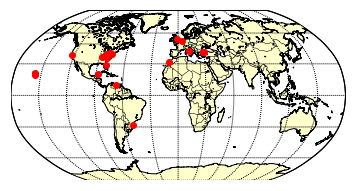

In [64]:
map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#FFFFCC') #http://www.w3schools.com/tags/ref_colorpicker.asp
map.drawmapboundary()
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

x,y = map(lons, lats)
map.plot(x, y, 'ro', markersize=6)
plt.show()

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


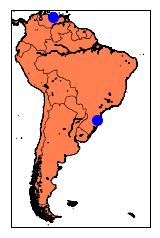

In [65]:
map = Basemap(projection='merc', lat_0 = -22, lon_0 = -56.5,resolution = 'h', area_thresh = 0.1, 
              llcrnrlon=-83.0, llcrnrlat=-57.0, urcrnrlon=-30.0, urcrnrlat=13.0)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=10)

plt.show()

Zoom em uma coordenada:

In [66]:
def gmap(lat,lon,zoom=10):
    # Google Maps URL template for an iframe
    google_maps_url = "http://maps.google.com/maps?q={0}+{1}&ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(lat,lon,zoom)
    display(IFrame(google_maps_url, '800px', '600px'))

In [67]:
gmap(lats[0],lons[0],4)

#### Graphs

http://networkx.lanl.gov/  

In [68]:
def get_rt_origins(tweet):
    ''' Regex adapted from 
    http://stackoverflow.com/questions/655903/python-regular-expression-for-retweets'''
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_origins = []
    try:
        rt_origins += [mention.strip() for mention in rt_patterns.findall(tweet)[0][1].split()]
    except IndexError as e:
        pass
    return [rto.strip("@") for rto in rt_origins]

In [69]:
def create_graph_retweets(tweets):
    g = nx.DiGraph()
    for tweet in tweets:
        rt_origins = get_rt_origins(tweet.text)
        if not rt_origins:
            continue
        for rt_origin in rt_origins:
            g.add_edge(rt_origin, tweet.user.screen_name, {'tweet_id': tweet.id})
    return g

In [70]:
g_rt = create_graph_retweets(tweets)
print("Number of nodes is: {}\n".format(g_rt.number_of_nodes()))
print("Number of edges is: {}\n".format(g_rt.number_of_edges()))

TypeError: add_edge() takes 3 positional arguments but 4 were given

In [ ]:
import operator
sorted_dic = sorted(g_rt.degree().items(), key=operator.itemgetter(1), reverse=True)
sorted_dic

In [ ]:
dic = nx.degree(g_rt)
plt.plot(sorted(dic.values()))

In [ ]:
def save_dotfile(g):
    try:
        nx.drawing.write_dot(g, pathdotfile)
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
    except (ImportError, UnicodeEncodeError, AttributeError): 
        # Este bloco serve para usuarios de windows, que certamente terao problemas
        # com o metodo nx.drawing.write_dot. Tambem serve para os casos em que temos
        # problemas com o unicode
        dot = [u'"{}" -> "{}" [tweet_id={}]'.format(n1, n2, g[n1][n2]['tweet_id']) for (n1, n2) in g.edges()]
        f = codecs.open(pathdotfile, 'w', encoding='utf-8')
        f.write('''strict digraph {{}}'''.format(';\n'.join(dot), ))
        f.close()
        print(sys.stderr, 'Graph exported for file: {}'.format(pathdotfile))
        return f.name

In [ ]:
save_dotfile(g_rt)

Saving a dotfile

Obs: To generate a png graph from the dotfile, type in the Unix Prompt: 
'circo -Tpng -Gcharset=latin1 -Ograph_retweet graph_retweet.dot'

In [ ]:
#Chamando um programa externo ao Ipython com o operador !
!dot -Tpng ../outputs/graph_retweet.dot -o ../outputs/graph_retweet.png
Image(pathpngfile)

In [ ]:
nx.draw_networkx_labels(g_rt,pos=nx.spring_layout(g_rt),font_size=9)
nx.draw(g_rt)
#nx.draw_random(g_rt)
#nx.draw_circular(g_rt)
#nx.draw_spectral(g_rt)

Saving a HTML file that uses javascript for visualizing the graph (needs a template)

In [ ]:
def save_protovis_file(g):
    '''A visualization alternative is "protovis" javascript
    It uses the files "template_protoviz.html and "protovis-r3.2.js"
    '''
    nodes = g.nodes()
    indexed_nodes = {}
    idx = 0
    for n in nodes:
        indexed_nodes.update([(n, idx,)])
        idx += 1
    links = []
    for n1, n2 in g.edges():
        links.append({'source': indexed_nodes[n2],'target': indexed_nodes[n1]})
    json_data = json.dumps({"nodes" : [{"nodeName" : n} for n in nodes], "links" : links}, indent=4)
    html = open(pathtemplate).read().format(json_data,)
    f = open(pathprotofile, 'w')
    f.write(html)
    f.close()
    print(sys.stderr, 'Graph exported for file: {}'.format(pathprotofile))
    return f.name, html

In [ ]:
s = save_protovis_file(g_rt)

In [ ]:
#!chromium ../outputs/graph_retweet.html
# http://docs.python.org/library/webbrowser.html 

webbrowser.open(pathprotofile)